In [1]:
import sys
sys.path.append('..')

In [2]:
import json

file = open('../data/Ferrara2023-citizens-individualChallenges.json')
file = [json.loads(line) for line in file]
filtered_data = [{
    'user': data['playerId'],
    'start': data['concept']['start'],
    'counter': data['concept']['fields']['counterName'],
    'target': data['concept']['fields']['target'],
    'periodTarget': data['concept']['fields']['periodTarget'],
    'completed': data['concept']['completed'],
} for data in file]

In [3]:
import pandas as pd
import numpy as np


df = pd.DataFrame(filtered_data)
df.dropna(subset=['counter'], inplace=True)
df.fillna(0, inplace=True)
df['target'] = df['target'].astype(int)
df['periodTarget'] = df['periodTarget'].astype(int)

df['start'] = pd.to_datetime(df['start'])
df['month'] = df['start'].dt.strftime('%B')
df = df[df['start'] < '2023-09-24'] # Last week of data is incomplete

df

,user,start,counter,target,periodTarget,completed,month
50,u_0bea6988-bd00-4aa6-a456-4285744356ee,2023-04-23 22:00:00,Walk_Km,1,0,True,April
51,u_0bea6988-bd00-4aa6-a456-4285744356ee,2023-04-23 22:00:00,green leaves,30,2,True,April
52,u_1636dfdc-fbcc-4068-8fcd-3293369c3a82,2023-04-23 22:00:00,Walk_Km,1,0,True,April
53,u_1636dfdc-fbcc-4068-8fcd-3293369c3a82,2023-04-23 22:00:00,green leaves,30,2,True,April
54,u_2fe7aac8-07da-4d38-8b0a-978be1986ebf,2023-04-23 22:00:00,Walk_Km,1,0,True,April
...,...,...,...,...,...,...,...
6517,u_f9994c4795f34970addeb5d3ca8ed1ab,2023-09-17 22:00:00,green leaves,45,2,True,September
6518,u_fa2d662c506d4605b9035c49622e0e83,2023-09-17 22:00:00,Walk_Km,1,0,False,September
6519,u_fa2d662c506d4605b9035c49622e0e83,2023-09-17 22:00:00,green leaves,30,2,False,September
6520,u_fa4965a5298e44e985afad963ee4acc8,2023-09-17 22:00:00,Walk_Km,1,0,True,September


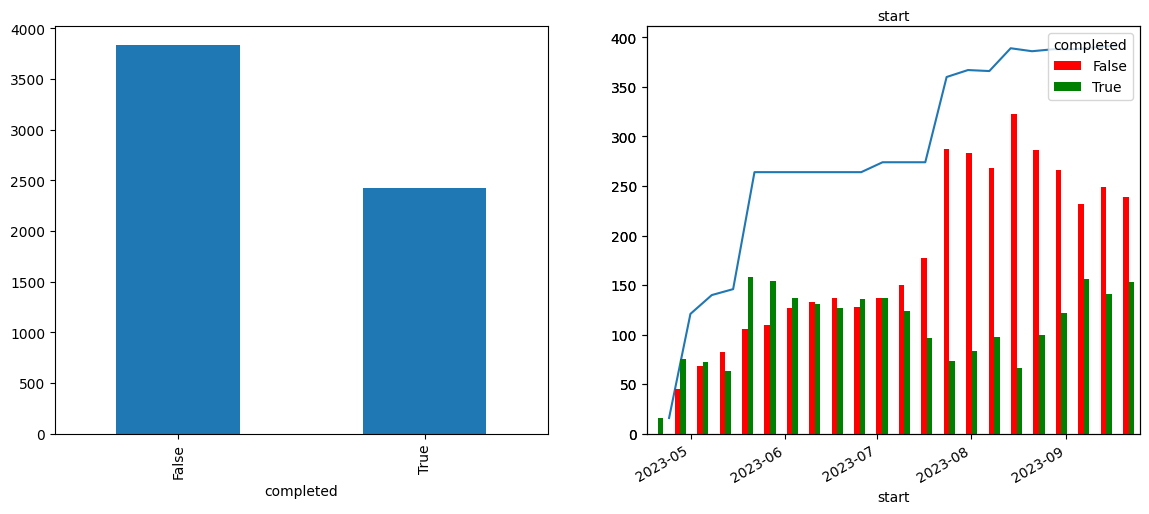

In [4]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 2, figsize=(14, 6))

df['completed'].value_counts().plot(kind='bar', ax=ax[0])
df.groupby('start').size().plot(ax=ax[1])

ax2 = ax[1].twiny()
df.groupby(['start', 'completed']).size().unstack().plot(kind='bar', ax=ax2, color=['red', 'green'])
ax2.set_xticks([])

plt.show()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

FEATURES = ['user', 'challenge', 'month']

dataset = df[[
    'start',
    *FEATURES,
    'completed'
]].copy()

dataset.sort_values(by=['start', 'user'], inplace=True, ignore_index=True)

encoder = OrdinalEncoder()
_ = encoder.fit_transform(dataset.drop(columns=['start', 'completed']), dataset['completed'])
features_dims = np.array([len(enc) for enc in encoder.categories_])
num_features = sum(features_dims)

print(features_dims)
num_features

In [ ]:
def train_test_split(df: pd.DataFrame):
    dates = np.sort(df['start'].unique())

    test = df[df['start'].isin(dates[-2:])]
    return test

dataset.sort_values(by=['start'], inplace=True)
test = dataset.groupby('user').apply(train_test_split, include_groups=False).reset_index().set_index('level_1')
train = dataset.drop(test.index)

train.drop(columns=['start'], inplace=True)
test.drop(columns=['start'], inplace=True)

y_train = train.pop('completed').values
y_test = test.pop('completed').values

X_train = encoder.transform(train)
X_test = encoder.transform(test)

In [ ]:
from src.FactorizationMachine import TwoWayFMDataset, TwoWayFM, fit, predict

train_dataset = TwoWayFMDataset(X_train, features_dims, y_train)
test_dataset = TwoWayFMDataset(X_test, features_dims)

model = TwoWayFM(num_features, 16)

fit(model, train_dataset, 10, 16)

y_pred = predict(model, test_dataset)

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

fpr, tpr, _ = roc_curve(y_test, y_pred)
ax1.plot(fpr, tpr)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.plot([0, 1], [0, 1], 'k--')

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax2.plot(recall, precision)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')

plt.show()

print('ROC AUC score', auc(fpr, tpr).round(2))
print('Precision-Recall AUC score', auc(recall, precision).round(2))

In [ ]:
from sklearn.metrics import classification_report

y_pred = np.array(y_pred) > 0.5

print(classification_report(y_test, y_pred))

In [ ]:
from itertools import product

queries = list(product(
    range(len(encoder.categories_[0])),
    range(len(encoder.categories_[1])),
    [5]
))

queries = TwoWayFMDataset(queries, features_dims)

predictions = predict(model, queries)

rec_df = pd.DataFrame(queries.X, columns=FEATURES)

rec_df['rating'] = predictions

rec_df[FEATURES] = encoder.inverse_transform(rec_df[FEATURES])
rec_df['counter'] = rec_df['challenge'].str.split('/').str[0]
rec_df

In [ ]:
top_k = rec_df.groupby(['user', 'counter']).apply(lambda x: x.nlargest(5, 'rating'), include_groups=False).reset_index()
top_k

In [ ]:
train['completed'] = y_train

train[train['user'] == 'u_0160059b315d4a9087e16cc31f7c7695']